/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59

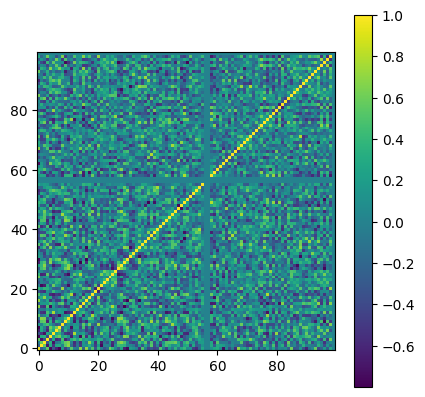

maxNumClusters50
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[2] clstrs len:3


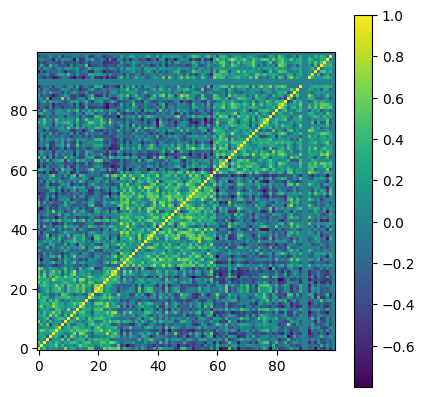

Cluster 0:
   Feature  Frequency
0        6         21
1        4         20
2        3         18
3       10         17
4        0         14
5        9         14
6        8         12
7       11         12
8        2         10
9        5         10
Cluster 1:
   Feature  Frequency
0        4         28
1        6         25
2        3         22
3       10         19
4       11         18
5        9         17
6        0         16
7        2         16
8       13         14
9        8         14
Cluster 2:
   Feature  Frequency
0        3         30
1        4         29
2        6         29
3       11         27
4       10         26
5        0         25
6        8         24
7       13         20
8        7         19
9        5         16


In [1]:
# -*- coding: utf-8 -*-
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, timezone
import pandas as pd
import pickle
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import DecisionTreeRegressor
"""## Formulas"""

def choose_position(roi, trade_threshold = 0.0001):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

"""# Function for data"""

def scale_data(data):
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)

    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)

    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

"""# Retrieve Top PNL"""

from sklearn.linear_model import Ridge

data = pd.read_csv('/kaggle/input/datatemp/save_data.csv')
data = data[data.Date >= '2021']
study = joblib.load(open("/kaggle/input/newdata-1k-trials/dtreemodel.pkl", "rb"))
trials = study.trials

completed_trials = [t for t in study.trials if t.values is not None]

# Sort the completed trials based on their objective values
completed_trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = completed_trials

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
    
    best_selected_features = [col for idx, col  in enumerate(new_df_no_close_col.columns) if trial.params[idx] == 1] # if bug try change from idx to col
    top_features_list.append(best_selected_features)

top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

pnl = pd.DataFrame(top_pnl)
pnl = pnl.transpose()

# Calculate the correlation matrix
corr_matrix = pnl.corr().abs()

# Create a mask to only look at the upper triangle (to avoid duplicate checks)
upper_triangle_mask = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > 0.8)]

# Drop the columns with high correlation
pnl_dropped = pnl.drop(columns=to_drop)

pnl_array = np.array(pnl_dropped.transpose())

# Identify columns with all zero values
cols_to_keep = ~np.all(pnl_array == 0, axis=0)

# Drop columns with all zero values
#pnl_array = pnl_array[:, cols_to_keep]

pnl_array = pnl_array[:100]

"""# ONC"""

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(pnl_array)
corr = pd.DataFrame(correlation_matrix)

corr= corr.fillna(0)

#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()


import pandas as pd

cluster_frequencies = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_features = top_trials[idx].number
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1],  reverse=True)

    print(f"Cluster {cluster_number}:")
    top_features = sorted_frequency[:10]
    df = pd.DataFrame(top_features, columns=['Feature', 'Frequency'])
    print(df)

cluster_lists = []

# Iterate through each cluster and its members and store to lists for each cluster
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    # print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.iloc[:, item]
  selected_columns_cluster.append(selected_columns) 

# Save to disk
with open('top_10_features_per_cluster.pkl', 'wb') as f:
    pickle.dump(top_10_features_per_cluster, f)

# Save to disk
with open('top_10_list.pkl', 'wb') as f:
    pickle.dump(selected_columns_cluster, f)